In [5]:
from langchain_openai import ChatOpenAI
from dotenv import load_dotenv 

load_dotenv()

import os
# DEEPSEEK_API_KEY = "sk-3938d707e5364e2f8580d5f096ba76ef"
# model = ChatOpenAI(
#     model="deepseek-chat", 
#     api_key=DEEPSEEK_API_KEY, 
#     base_url="https://api.deepseek.com",

#     temperature=0.0
# )
# model.invoke("suggest some ways to reduce my gst tax scenario[ Me and my wife have dance partnership firm  where we conduct online and offline class from 2019 to 2024 we paid around 50 laks as gst is there any way to reduce this cost ] suggest me some ways to reduce .we can do it in any way. give the very human understandable result becuase i don't have any knlowlegtool_with_llme of gst")


In [6]:
os.environ['OPENAI_API_KEY'] = os.getenv("OPENAI_API_KEY")


In [7]:
# load the data file and perform the chunking 

# doc_dir = "../data/unstructured_docs/stories/stories.pdf"
chunk_size = 500
chunk_overlap = 100
embedding_model = 'text-embedding-3-small'
vectordb_dir = './DATA'
collection_name = 'rag-gst'
pdf_file_name = '../data/unstructured_docs/swiss_airline_policy/Notification12-CGST.pdf'
llm = 'o1-mini' 

from pyprojroot import here

# check if the vectordb file exist generated or not if not create

llm = ChatOpenAI(model=llm)
llm.invoke("Select the number from among the given options that can replace the question mark (?) in the following series. 28, 32, 41, 57 ?.## i want one line answere")

AIMessage(content='The next number is **82**.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 152, 'prompt_tokens': 47, 'total_tokens': 199, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 128, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'o1-mini-2024-09-12', 'system_fingerprint': 'fp_f56e40de61', 'finish_reason': 'stop', 'logprobs': None}, id='run-606d7aaa-f815-4b0e-94f3-b64d7483b738-0', usage_metadata={'input_tokens': 47, 'output_tokens': 152, 'total_tokens': 199, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 128}})

In [8]:
llm.invoke("suggest some ways to reduce my gst tax scenario[ Me and my wife have dance partnership firm  where we conduct online and offline class from 2019 to 2024 we paid around 50 laks as gst is there any way to reduce this cost ] suggest me some ways to reduce .we can do it in any way. give the very human understandable result becuase i don't have any knowledge of gst").content

'Reducing your GST (Goods and Services Tax) liability is essential for optimizing your business finances. Here are several strategies you can consider to potentially lower the GST you and your wife’s dance partnership firm have been paying:\n\n### 1. **Claim All Eligible Input Tax Credits (ITC)**\n**What It Is:** ITC allows you to deduct the GST you’ve paid on business-related purchases and expenses from the GST you owe on your sales.\n\n**How to Optimize:**\n- **Maintain Detailed Records:** Keep all your invoices, bills, and receipts organized. Ensure that every purchase that qualifies for ITC is documented.\n- **Regular Reconciliation:** Periodically reconcile your purchase records with your GST filings to ensure you’re claiming all eligible credits.\n- **Exclude Personal Expenses:** Only claim ITC on expenses that are directly related to your dance classes.\n\n### 2. **Choose the Correct GST Rate for Your Services**\n**What It Is:** GST rates vary based on the type of service you pr

In [13]:
from langchain_community.document_loaders import PyPDFLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter

# Load the PDF and split it
docs = PyPDFLoader(pdf_file_name).load_and_split()

# Split text using RecursiveCharacterTextSplitter
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=chunk_size, chunk_overlap=chunk_overlap
)

doc_splits = text_splitter.split_documents(docs)


In [14]:

# store the data in vector db(chromadb)
from langchain_openai import OpenAIEmbeddings
from langchain_chroma import Chroma

vectordb = Chroma.from_documents(
    documents=doc_splits,
    collection_name=collection_name,
    embedding=OpenAIEmbeddings(model = embedding_model),
    persist_directory=str(vectordb_dir)
)

In [15]:
vectordb.similarity_search("heading 9954")

[Document(metadata={'page': 5, 'source': '../data/unstructured_docs/swiss_airline_policy/Notification12-CGST.pdf'}, page_content='6 \n \nthis entry shall apply on or after the \nexpiry of a period of one year f rom the \ndate of commencement of operations of \nthe regional connectivity scheme airport \nas notified by the Ministry of Civil \nAviation. \n17 Heading 9964 Service of transportation of passengers, \nwith or without accompanied belongings, \nby—  \n(a) railways in a class other than—  \n(i) first class; or  \n(ii) an air-conditioned coach;  \n(b) metro, monorail or tramway;  \n(c) inland waterways;  \n(d) public transport, other than \npredominantly for tourism purpose, in a \nvessel between places located in Indi a; \nand  \n(e) metered cabs or auto rickshaws \n(including e-rickshaws).  \nNil Nil \n18 Heading 9965  \n \nServices by way of transportation of \ngoods-  \n(a) by road except the services of— \n(i) a goods transportation agency;  \n(ii) a courier agency; \n(b) by 

In [16]:
EMBEDDING_MODEL = "text-embedding-3-small"
VECTORDB_DIR = "./DATA"
K = 2


from langchain_core.tools import tool


@tool
def look_gst_data(query:str)->str:
    """
    your full resonsible to answere the Goods and Services Tax (INDIA) present in documents
    """
    vectordb = Chroma(
        collection_name=collection_name,
        persist_directory=vectordb_dir,
        embedding_function=OpenAIEmbeddings(model=embedding_model)
    )
    
    docs = vectordb.similarity_search(query=query,k=3)
    return "\n\n".join([doc.page_content for doc in docs])

In [17]:
 # Webscrappig Tool

from langchain_community.document_loaders import WebBaseLoader

from bs4 import BeautifulSoup
import requests



def crawl_site_for_pdfs(base_url, visited=set()):
    """Recursively crawl the site to find all PDF links."""
    response = requests.get(base_url)
    if response.status_code != 200:
        return []

    soup = BeautifulSoup(response.text, 'html.parser')
    pdf_links = []

    # Find all links
    for link in soup.find_all('a', href=True):
        href = link['href']
        # Check if it's a PDF
        if href.endswith('.pdf'):
            full_url = href if href.startswith('http') else base_url + href
            pdf_links.append(full_url)
        # Crawl other pages on the same domain
        elif base_url in href and href not in visited:
            visited.add(href)
            pdf_links.extend(crawl_site_for_pdfs(href, visited))

    return pdf_links

# Start crawling
all_pdf_links = crawl_site_for_pdfs("https://www.icai.org/post/19142")
print(f"Total PDFs found: {len(all_pdf_links)}")



In [18]:
# from langchain.document_loaders import WebBaseLoader

# # List of PDF URLs (obtained from the previous step)
# all_pdf_links

# # Load each PDF using WebBaseLoader
# documents = []
# for pdf_url in all_pdf_links:
#     loader = WebBaseLoader(pdf_url)
#     documents.extend(loader.load())

# # Display content of the loaded documents
# for i, doc in enumerate(documents):
#     print(f"Document {i+1}:")
#     print(doc.page_content[:500])  # Print the first 500 characters


In [19]:
# documents[0]

In [20]:
# test the agent of gst lookup tool

look_gst_data.invoke("what is 9954")

# you should treat yourself as the Goods and Services Tax expert you work specially around the indian goods and service tax (GST) if user can as the any query based on their business need try to solve.if user providing his business detail with number perform the calculation and give the solid answere and also you have reasoning ability

'11 \n \n40 Heading 9971 \nor \nHeading 9991 \n \nServices provided to the Central \nGovernment, State Government, Union \nterritory under any insurance scheme for \nwhich total premium is paid by the \nCentral Government, State Government,  \nUnion territory. \nNil Nil \n41 Heading 9972 One time upfront amount (called as \npremium, salami, cost, price, development \ncharges or by any other name) leviable in \nrespect of  the service, by way of granting \nlong term (thirty years, or more) lease of \nindustrial plots, provided by the State \nGovernment Industrial Development \nCorporations or Undertakings to industrial \nunits. \nNil Nil \n42 Heading 9973  \nor \nHeading 9991 \nServices provided by the Central \nGovernment, State Government, Union \nterritory or local au thority by way of \nallowing a business entity to operate as a \ntelecom service provider or use radio \nfrequency spectrum  during the period \nprior to the 1st April, 2016, on payment of \nlicence fee or spectrum user

In [21]:
# create llm as tool 

# large lang model o1-mini
from langchain.schema import SystemMessage,HumanMessage

@tool
def get_llm_tool(query: str) -> str:
    """
    Treat yourself as an expert in Indian Goods and Services Tax (GST). You should:
    - Solve user queries based on their business needs.
    - Perform calculations if business details with numbers are provided.
    - Provide solid, actionable answers with reasoning and clarity.
    """

    # Crafting the prompt
    custom_prompt = (
        "You are an expert in Indian Goods and Services Tax (GST). Your role is to provide **practical and actionable solutions** "
        "for GST-related queries. Follow these guidelines to ensure focused, result-oriented responses:\n"
        "1. Solve the user's query based on their business needs with **step-by-step actionable advice** that can be implemented directly.\n"
        "2. If business details with numbers are provided, perform **detailed calculations** based on GST rules and present the results clearly.\n"
        "3. Avoid lengthy theoretical explanations. Focus on **applicable GST rules, exemptions, credits, and liabilities** to address the user's situation.\n"
        "4. Use reasoning, examples, or real-world approaches only when necessary to clarify complex points or justify your calculations.\n"
        "5. Always deliver a **clear, concise, and implementable answer**.\n\n"
        "User Query:\n"
        f"{query}\n\n"
        "Your response should be easy to understand, focused on practical outcomes, and include any calculations or GST rules applied to the solution."
    )


    # Initialize the ChatOpenAI LLM
    llm = ChatOpenAI(model="o1-preview")

    # Invoke the LLM with the crafted prompt
    response = llm.invoke(custom_prompt)

    # Return the LLM's response content
    return response.content



# get_llm_tool.invoke("suggest some ways to reduce my gst tax scenario[ Me and my wife have dance partnership firm  where we conduct online and offline class from 2019 to 2024 we paid around 50 laks as gst is there any way to reduce this cost ] suggest me some ways to reduce .we can do it in any way. give the very human understandable result becuase i don't have any knlowlegtool_with_llme of gst")

# get_llm_tool.invoke("Select the number from among the given options that can replace the question mark (?) in the following series. 28, 32, 41, 57 i want one line answere")



In [22]:
llm = ChatOpenAI(model="gpt-4o",temperature=0)

tool = [look_gst_data, get_llm_tool]

tool_with_llm = llm.bind_tools(tools=tool)

# tool_with_llm.invoke("suggest some ways to reduce my gst tax scenario[ Me and my wife have dance partnership firm  where we conduct online and offline class from 2019 to 2024 we paid around 50 laks as gst is there any way to reduce this cost ] suggest me some ways to reduce .we can do it in any way. give the very human understandable result becuase i don't have any knlowlege of gst").content


In [23]:

tool_with_llm.invoke("hi my name is ankit")

AIMessage(content='Hello Ankit! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 13, 'prompt_tokens': 131, 'total_tokens': 144, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_50cad350e4', 'finish_reason': 'stop', 'logprobs': None}, id='run-871e49fc-f035-40d2-bf0f-52475c626373-0', usage_metadata={'input_tokens': 131, 'output_tokens': 13, 'total_tokens': 144, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})

In [24]:
tool_with_llm.invoke("what is gst")

AIMessage(content='The Goods and Services Tax (GST) is a comprehensive indirect tax levied on the supply of goods and services in India. It is a single tax on the supply of goods and services, right from the manufacturer to the consumer. GST is designed to be a unified tax system that replaces multiple indirect taxes previously levied by the central and state governments, such as excise duty, VAT, service tax, etc.\n\nKey features of GST include:\n\n1. **Dual Structure**: GST in India is a dual system, meaning it is administered both by the central and state governments. It comprises:\n   - Central GST (CGST) - levied by the Central Government.\n   - State GST (SGST) - levied by the State Governments.\n   - Integrated GST (IGST) - levied on inter-state supply of goods and services.\n\n2. **Destination-Based Taxation**: GST is a destination-based tax, meaning the tax is collected by the state where the goods or services are consumed, rather than where they are produced.\n\n3. **Input Ta

In [25]:
tool_with_llm.invoke("Select the number from among the given options that can replace the question mark (?) in the following series. 28, 32, 41, 57 ?.## i want one line answere")

AIMessage(content='The number that can replace the question mark (?) in the series is 80.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 18, 'prompt_tokens': 164, 'total_tokens': 182, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_50cad350e4', 'finish_reason': 'stop', 'logprobs': None}, id='run-30285efc-44fa-490c-9b38-4c5234a7fd76-0', usage_metadata={'input_tokens': 164, 'output_tokens': 18, 'total_tokens': 182, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})

In [26]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START
from langgraph.graph.message import add_messages


class State(TypedDict):
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)

In [27]:
def chatbot(state: State):
    return {"messages": [tool_with_llm.invoke(state["messages"])]}

graph_builder.add_node("chatbot", chatbot)

In [28]:
import json
from langchain_core.messages import ToolMessage

import sys
class BasicToolNode:
    """A node that runs the tools requested in the last AIMessage."""

    def __init__(self, tools: list) -> None:
        self.tools_by_name = {tool.name: tool for tool in tools}

    def __call__(self, inputs: dict):
        if messages := inputs.get("messages", []):
            message = messages[-1]
        else:
            raise ValueError("No message found in input")
        outputs = []
        for tool_call in message.tool_calls:
            

            tool_result = self.tools_by_name[tool_call["name"]].invoke(
                tool_call["args"]
            )

            outputs.append(
                ToolMessage(
                    content=json.dumps(tool_result),
                    name=tool_call["name"],
                    tool_call_id=tool_call["id"],
                )
            )

        return {"messages": outputs}

# {'name': 'get_llm_tool', 'args': {'query': 'Can I cancel my flight ticket 10 hours before the flight?'}, 'id': 'call_EdbO9kD3zXZ8vwohG5kEEiYm', 'type': 'tool_call'}

tool_node = BasicToolNode(tools=[look_gst_data,get_llm_tool])

graph_builder.add_node("tools", tool_node)

In [29]:
from langgraph.graph import END, MessagesState
from typing import Literal

# Define the function that determines whether to continue or not
def should_continue(state: MessagesState) -> Literal["tools", END]:
    messages = state['messages']
    last_message = messages[-1]
    # If the LLM makes a tool call, then we route to the "tools" node
    if last_message.tool_calls:
        return "tools"
    # Otherwise, we stop (reply to the user)
    return END

graph_builder.add_conditional_edges(
    "chatbot",
    should_continue,
    ["tools", END],
)
# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

In [30]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()
graph = graph_builder.compile(checkpointer=memory)

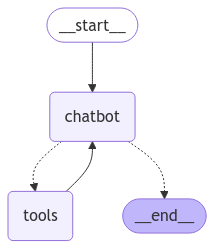

In [31]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [32]:
save = False

if save:
    from PIL import Image as PILImage
    import io
    # Assuming graph.get_graph().draw_mermaid_png() returns PNG binary data
    try:
        # Generate the PNG image from the graph
        png_data = graph.get_graph().draw_mermaid_png()
        
        # Convert the binary data into an image
        img = PILImage.open(io.BytesIO(png_data))
        
        # Save the image locally with 300 DPI
        img.save('output_image.png', 'PNG', dpi=(300, 300))
        
        print("Image saved successfully with 300 DPI.")
    except Exception as e:
        print(f"Error: {e}")

In [33]:
config = {"configurable": {"thread_id": "1"}}

In [34]:
user_input = "Hi there! My name is Farzad."

# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [("user", user_input)]}, config, stream_mode="values"
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Hi there! My name is Farzad.
================================== Ai Message ==================================

Hello Farzad! How can I assist you today?


In [36]:
# user_input = "Select the number from among the given options that can replace the question mark (?) in the following series. 28, 32, 41, 57?"
user_input = "suggest some ways to reduce my gst tax scenario"
user_input = "Me and my wife have dance partnership firm  where we conduct online and offline class from 2019 to 2024 we paid around 50 laks as gst is there any way to reduce this cost. suggest me some ways to reduce "
# user_input = "Select the number from among the given options that can replace the question mark (?) in the following series. 28, 32, 41, 57 ?"
user_input = "please help me understand the tax liability from this sale of apartment  Bought flat in 2007 for 14lkah Sold it in Dec 2024 for 45 Lakh Am i eligible to get indexation benefit What would be the tentative tax liability - if eligible for indexation Is it worth to invest the proceeds in another flat of 60lakh(which will have 7-9% tax and administrative charges additional), or invest it in a Mutual Fund lumpsum"
user_input = "what is Heading 9964"

events = graph.stream(
    {"messages": [("user", user_input)]}, config, stream_mode="values"
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

what is Heading 9964
================================== Ai Message ==================================
Tool Calls:
  look_gst_data (call_mxEeod50SlqbwuOuoaz4NiEU)
 Call ID: call_mxEeod50SlqbwuOuoaz4NiEU
  Args:
    query: Heading 9964
================================= Tool Message =================================
Name: look_gst_data

"6 \n \nthis entry shall apply on or after the \nexpiry of a period of one year f rom the \ndate of commencement of operations of \nthe regional connectivity scheme airport \nas notified by the Ministry of Civil \nAviation. \n17 Heading 9964 Service of transportation of passengers, \nwith or without accompanied belongings, \nby\u2014  \n(a) railways in a class other than\u2014  \n(i) first class; or  \n(ii) an air-conditioned coach;  \n(b) metro, monorail or tramway;  \n(c) inland waterways;  \n(d) public transport, other than \npredominantly for tourism purpose, in a \nvesse

In [ ]:
# Here's a detailed breakdown of your tax liability from the sale of your apartment and the potential investment options:

# ### Tax Liability Calculation

# 1. **Indexed Cost of Acquisition (ICOA):**
#    - **Original Purchase Price (2007):** ₹14,00,000
#    - **Cost Inflation Index (CII) for 2007-08:** 129
#    - **Estimated CII for 2024-25:** 365 (estimated based on historical trends)

#    \[
#    \text{ICOA} = \text{Original Cost} \times \left( \frac{\text{CII in Year of Sale}}{\text{CII in Year of Purchase}} \right) = ₹14,00,000 \times \left( \frac{365}{129} \right) \approx ₹39,60,161
#    \]

# 2. **Long-Term Capital Gain (LTCG):**
#    - **Sale Price (Dec 2024):** ₹45,00,000
#    - **LTCG = Sale Price - ICOA = ₹45,00,000 - ₹39,60,161 = ₹5,39,839**

# 3. **Tax Liability:**
#    - **Tax Rate on LTCG:** 20%
#    - **Health and Education Cess:** 4%

#    \[
#    \text{Basic Tax} = 20\% \times ₹5,39,839 = ₹1,07,968
#    \]
#    \[
#    \text{Cess} = 4\% \times ₹1,07,968 = ₹4,319
#    \]
#    \[
#    \text{Total Tax Liability} = ₹1,07,968 + ₹4,319 = ₹1,12,287
#    \]

# **Your approximate tax liability is ₹1,12,287.**

# ### Investment Options

# #### Option 1: Invest in Another Residential Property (Section 54)
# - **Reinvest the LTCG amount of ₹5,39,839 in a new residential property.**
# - **Benefits:** Full exemption of LTCG tax on the amount invested.
# - **Conditions:** Purchase within 2 years or construct within 3 years; the new property must be in India.

# #### Option 2: Invest in Specified Bonds (Section 54EC)
# - **Invest the LTCG amount in government-specified bonds (e.g., NHAI, REC bonds).**
# - **Benefits:** Exemption of LTCG tax up to the amount invested.
# - **Lock-in Period:** 5 years.

# #### Option 3: Pay the Tax and Invest Freely
# - **Pay the LTCG tax of ₹1,12,287.**
# - **Benefits:** No restrictions on how you use the remaining sale proceeds.
# - **Consideration:** You can invest the remaining amount in mutual funds or other investment options.

# ### Recommendation

# - **If Tax Saving is Your Priority:**
#   - **Invest in Another Residential Property:** Offers full tax exemption but requires significant capital commitment.
#   - **Invest in Specified Bonds:** Provides tax exemption with a smaller investment and less capital outlay.

# - **If Investment Flexibility and Liquidity are Important:**
#   - **Pay the LTCG Tax:** After paying the tax, you have the freedom to invest the remaining funds as you wish, such as in mutual funds.

# Make a decision based on your financial situation, investment horizon, and risk appetite to optimize your tax liability and meet your financial goals.


In [4]:
# ndexed property value = 14 * 363 / 129 = 39.39 CII table

# CG with indexation rule = 6L, tax = 1.2L

# CG without indexation = 31, tax 3.9L.

# Actual tax liability = min(1.2,3.9) = 1.2L

# I would invest in MF instead of bothering with saving 1.2L tax.